# Einfaches RNN-Netz

Versuch mit größerer Subsample-Länge schlechtere Ergebnisse

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, metrics, manifold
from tensorflow import keras
import keras_tuner as kt

import prepare

2025-01-03 13:27:33.979539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 13:27:34.074200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 13:27:34.101278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 13:27:34.429343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER
SUBSAMPLE_LEN = 25

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train_valid, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train, versuche_valid = model_selection.train_test_split(versuche_train_valid, test_size=0.1, random_state=42)
versuche_train.shape, versuche_valid.shape, versuche_test.shape

((432, 5), (48, 5), (120, 5))

Subsampling

In [7]:
subsample2 = prepare.Subsample2(SUBSAMPLE_LEN)
subsample2.fit() # dummy

Subsample2(subsample=25)

In [8]:
X_train = subsample2.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))
X_valid = subsample2.transform(versuche_valid.key, kurven)
label_valid = versuche_valid.label.values
festigkeit_valid = versuche_valid.festigkeit.values
print(X_valid.shape, label_valid.shape)
print(X_valid.max(axis=(0,1)))

#festigkeit_train

(432, 25, 3) (432,)
[3600.84   625.019    4.13 ]
(48, 25, 3) (48,)
[3456.32  619.16    3.98]


In [9]:
X_test = subsample2.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 25, 3)
[3511.71     621.113      3.81001]


Skalieren Trainingsdaten

In [10]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)
X_valid_scaled = tsMaxScale.transform(X_valid)

Skalieren Testdaten

In [11]:
X_test_scaled = tsMaxScale.transform(X_test)

In [12]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

Anzeige Kurven zur Kontrolle.

Text(0.5, 1.0, 'Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert')

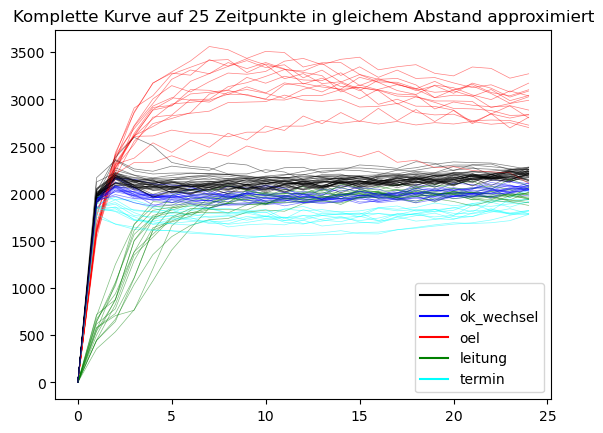

In [13]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
plt.title("Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert")

Alle Features verwenden

In [45]:
dims = X_train.shape
#X2_train = X_train_scaled.reshape(-1, dims[1]*dims[2])
#X2_test = X_test_scaled.reshape(-1, dims[1]*dims[2])
#X2_train = X_train_scaled[:,:,0]
#X2_valid = X_valid_scaled[:,:,0]
#X2_test = X_test_scaled[:,:,0]
X2_train = X_train_scaled
X2_valid = X_valid_scaled
X2_test = X_test_scaled
X2_train.shape

(432, 25, 3)

Hyperparametersuche

- mehrere GRU-Schichten
- ein breiter Dense-Layer
- ein Dense-Layer zum Zusammenfassen
- Umskalieren Ergebnis

In [15]:
def build_class(hp):
    n_gru = hp.Int("n_gru", min_value=2, max_value=6, default=2)
    #n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=2)
    n_neurons = hp.Int("n_neurons", min_value=64, max_value=512)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=5e-3, sampling='log')
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X2_train.shape[1:]))
    for _ in range(n_gru-1):
        model.add(keras.layers.GRU(n_neurons, return_sequences=True))
    model.add(keras.layers.GRU(n_neurons))
    model.add(keras.layers.Dense(n_neurons, use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.add(keras.layers.Lambda(lambda x: x*2000.0))
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model
    

In [16]:
random_search_tuner = kt.RandomSearch(
    build_class, objective='val_loss', max_trials=20,
    overwrite=True, directory='rnn1', project_name='rnn1_reg',
)
random_search_tuner.search(X2_train, festigkeit_train, epochs=30, batch_size=8,
    validation_data=(X2_valid, festigkeit_valid)
)

Trial 20 Complete [00h 00m 34s]
val_loss: 1430625.0

Best val_loss So Far: 44195.30078125
Total elapsed time: 00h 06m 59s


In [27]:
model_reg = random_search_tuner.get_best_models(num_models=1)[0]
hp = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
hp.values


/opt/miniconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'n_gru': 4, 'n_neurons': 258, 'learning_rate': 0.0007507314038442856}

In [28]:
hp = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
hp.values

{'n_gru': 4, 'n_neurons': 258, 'learning_rate': 0.0007507314038442856}

In [29]:
model_reg = random_search_tuner.get_best_models(num_models=1)[0]
model_reg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 25, 258)        │       203,562 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 25, 258)        │       400,932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 25, 258)        │       400,932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 258)            │       400,932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 258)            │        66,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 258)            │         1,032 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 258)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           259 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,474,213 (5.62 MB)

 Trainable params: 1,473,697 (5.62 MB)

 Non-trainable params: 516 (2.02 KB)

Manuelles Modell aus mehreren Hyperparametersuchen

In [46]:
model_reg = keras.models.Sequential()
model_reg.add(keras.layers.Input(shape=X2_train.shape[1:]))
model_reg.add(keras.layers.GRU(128, return_sequences=True))
model_reg.add(keras.layers.GRU(128, return_sequences=True))
model_reg.add(keras.layers.GRU(128, return_sequences=True))
model_reg.add(keras.layers.GRU(128))
model_reg.add(keras.layers.Dense(100, activation='relu'))
model_reg.add(keras.layers.Dense(1))
model_reg.add(keras.layers.Lambda(lambda x: x*2000))

model_reg.compile(
    loss='mse',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0008)
)

model_reg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 25, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 25, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 25, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,289 (1.38 MB)

 Trainable params: 361,289 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
hist = model_reg.fit(X2_train, festigkeit_train, epochs=30, batch_size=8,
    validation_data=(X2_valid, festigkeit_valid)
)

Epoch 1/30


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1802311.5000 - val_loss: 250886.4219
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 201047.0156 - val_loss: 31306.6621
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 88639.7344 - val_loss: 22093.7246
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 50122.0078 - val_loss: 26883.6230
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 49195.2969 - val_loss: 21511.1543
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57856.4297 - val_loss: 46477.4258
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 48886.3203 - val_loss: 58260.1289
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 56800.2422 - val_loss: 91823.2109
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55512.2500 - val_loss: 29750.7832
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 49010.8359 - val_loss: 26927.0469
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 50858.2344 - val_loss: 231

<Axes: >

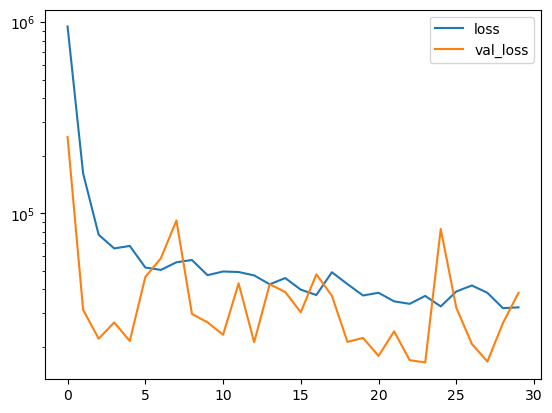

In [48]:
pd.DataFrame(hist.history).plot(logy=True)

Vorhersage Trainingsdaten

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


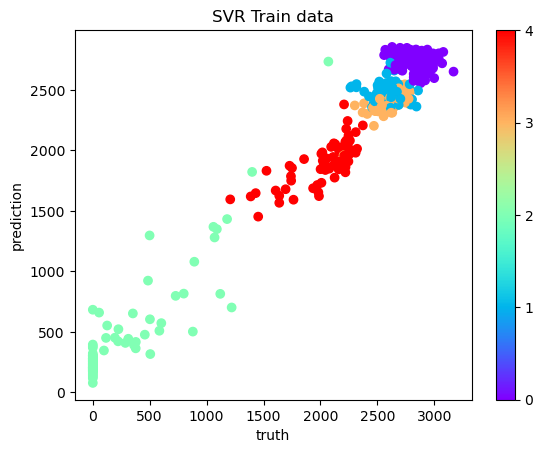

In [49]:
y_pred_train = model_reg.predict(X2_train)#*SCALE_FEST
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('ann1_train.png')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


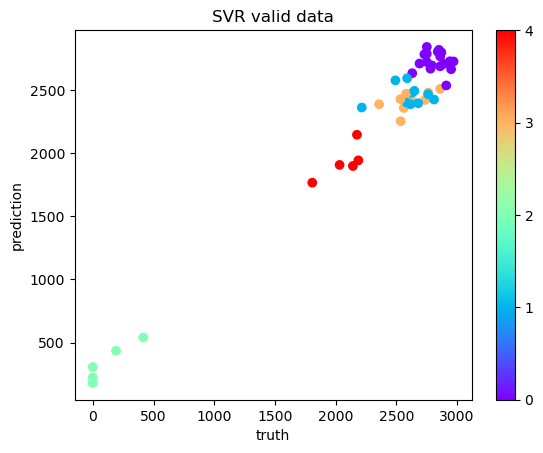

In [50]:
y_pred_valid = model_reg.predict(X2_valid)#*SCALE_FEST
plt.scatter(festigkeit_valid, y_pred_valid, c=label_valid, cmap='rainbow')
plt.title('SVR valid data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('ann1_valid.png')

Vorhersage Testdaten

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


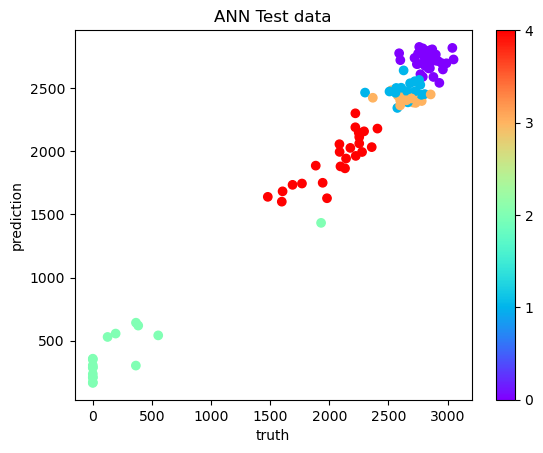

In [51]:
y_pred_test = model_reg.predict(X2_test)#*SCALE_FEST
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
#plt.plot([0, 3000], [0,3000], "k:")
plt.title('ANN Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('ann1_test.png')

In [52]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train  47519.2, test:  43920.1
RMSE: train    218.0 test:    209.6
MAE: train    185.3, test:    177.6
